# pyQUEIJU: run QE from jupyter

**pyQUEIJU: QUantum Espresso Interface on JUpyter**

In this example we use pyQUEIJU to obtain and plot the graphene bands.

In my server the QE binaries are placed within the $PATH. But if yours are not, you can inform the correct path at the object initialization.

In [1]:
# we'll need these to plot the bands
import numpy as np
import matplotlib.pyplot as plt

# add pyqueiju module folder to the pythonpath
# or save the module within your pythonpath to avoid these lines
import sys
sys.path.append('./pyqueiju')

# import the module itself
from pyqueiju import queiju

## How to use it

- To create an instance call:

> `relax = queiju(relax_in, qe_path)`

or

> `relax = queiju(relax_in)`

where `relax_in` is the string with the QE input data (see below in the examples) and `qe_path` is the path to the QE binaries. If the binaries are on $PATH, we can ommit `qe_path=""` as in the second line above. Here we are calling this instance **relax**, but use an appropriate name for the type of calculation you are calling (relax, scf, nscf, bands, ...)

- To run, call the `run` method informing the proper binary:

> `relax.run("pw.x")`

- To see the output, either print to screen or save to an external file as

> `print(relax.out)`

> `relax.saveoutput('relax.out')`

- A list of files created or modified by the QE run is available at

> `print(relax.files)`

### Creating scripts to go from relax to scf, etc...

Check the example below. It is much easier to build python scripts using the structure above instead of going to a terminal or running bash scripts.

### For more information

Check the gitlab webpage and our **TO DO LIST** at the board.

## 1 - Relaxation

In [2]:
#########################
# DEFINE the input file #
#########################
relax_in = """
&CONTROL
    calculation='vc-relax'
    prefix='graphene'
    restart_mode='from_scratch'
    outdir='./outdir'
    pseudo_dir='/home/gerson/pseudo'
/
&SYSTEM
    ibrav = 4, a = 2.460, c= 20,
    nat = 2, ntyp = 1,
    ecutwfc = 40.0 ,
    ecutrho = 400.0 ,
    occupations = 'smearing', degauss = 0.0001, smearing = 'marzari-vanderbilt',
    assume_isolated = '2D'
/
&ELECTRONS
    conv_thr = 1.0d-8,
    mixing_beta = 0.3,
/
&IONS
/
&CELL
    cell_dofree = '2Dxy'
/
ATOMIC_SPECIES
C 12.0107 C.pbe-n-kjpaw_psl.1.0.0.UPF
ATOMIC_POSITIONS crystal
C 0.000000000 0.000000000 0.250000000
C 0.333333333 0.666666667 0.250000000
K_POINTS automatic
12 12 1 0 0 0
"""

In [3]:
# initializes the object and runs the code
relax = queiju(relax_in)
print("It took ", relax.run("pw.x"), " seconds")

It took  82.04520288505591  seconds


In [1]:
# to prints the full output, run
print(relax.out)
# if you want to save the output to a file, run
relax.saveoutput('relax.out')

In [2]:
# to print the list of new or modified files
print(relax.files)

In [7]:
# Extract final coordinates to compare with the input file
#
# In this case the input file was already ok, so we don't need to change it.

id0 = relax.out.find('Begin final coordinates')
id1 = relax.out.find('End final coordinates') # 21 characters
print(relax.out[id0:id1+21])

Begin final coordinates
     new unit-cell volume =    710.60042 a.u.^3 (   105.30012 Ang^3 )
     density =      0.37881 g/cm^3

CELL_PARAMETERS (alat=  4.64872629)
   1.002302945   0.000000000   0.000000000
  -0.501151472   0.868019813   0.000000000
   0.000000000   0.000000000   8.130081301

ATOMIC_POSITIONS (crystal)
C        0.000000000   0.000000000   0.250000000
C        0.333333333   0.666666667   0.250000000
End final coordinates


##  2 - Self-consistent calculation

In this case we use the same input file from the relaxation because the lattice parameters were already fine. Therefore it is sufficient to change the calculation parameter from *vc-relax* to *scf*.

To keep it all stored in different objects, here we initialize a new NAQUEI object.

In [8]:
# replace 'vc-relax' with 'scf'
scf_in = relax_in.replace('vc-relax', 'scf', 1)
# print(scf_in) # to see the input

In [9]:
# initializes the object and runs the code
scf = queiju(scf_in)
print("It took ", scf.run("pw.x"), " seconds")

It took  10.082718066871166  seconds


In [3]:
# to print the full output, run
print(scf.out)
# if you want to save the output to a file, run
scf.saveoutput('scf.out')

In [4]:
# to print the list of new or modified files
print(scf.files)

## Bands

To prepare the bands input, we use the scf input above and

- replace the calculation from scf to bands
- remove the K_POINTS section to replace it with a k-path
- attach the k-path and bands parameters to the input
- run pw.x and then bands.x

In [12]:
bands_in = scf_in.replace('scf', 'bands', 1) # replace scf with bands
id0 = bands_in.find('K_POINTS') # find where K_POINTS start
bands_in = bands_in[:id0] # remove from K_POINTS to the end
bands_in += """K_POINTS crystal_b
4
+0.0000000000 0.000000000 0.000000000 30 ! G
-0.3333333333 0.666666667 0.000000000 30 ! K
+0.0000000000 0.500000000 0.000000000 30 ! M
+0.0000000000 0.000000000 0.000000000 30 ! G
&bands
outdir = './outdir'
prefix = 'graphene'
filband = 'graphene.bands.dat'
/
"""
#print(bands_in)

In [13]:
# initializes the object and runs the code
bands = queiju(bands_in)
plot = queiju(bands_in)
# run both objects
print("It took ", bands.run("pw.x"), " seconds")
print("It took ", plot.run("bands.x"), " seconds")

It took  20.829707358032465  seconds
It took  15.834395329002291  seconds


In [14]:
#print(bands.files)
print(plot.files)

./graphene.bands.dat.rap
./graphene.bands.dat
./outdir/graphene.wfc1
./graphene.bands.dat.gnu



## Plot bands

In [16]:
# TO DO: extract filename automatically
data = np.loadtxt('graphene.bands.dat.gnu')
data.shape

(728, 2)

In [17]:
# TO DO: extract the Fermi energy automatically from the scf output
id0 = scf.out.find('the Fermi energy is')
print(scf.out[id0:(id0+33)])
fermi = -4.2181

the Fermi energy is    -4.2181 ev


In [18]:
# TO DO: extract k-points automatically
kpath = [data[ 0,0], data[30,0], data[60,0], data[90,0]]
klabel = [R'$\Gamma$', R'$K$', R'$M$', R'$\Gamma$']

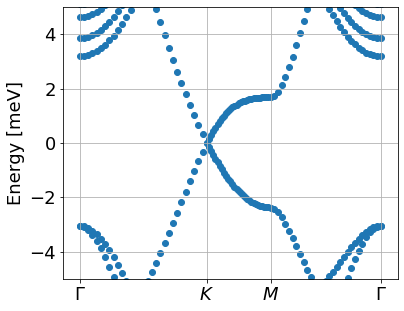

In [19]:
plt.figure(figsize=(6,5))
plt.rcParams.update({'font.size': 18})
plt.clf()

plt.scatter(data[:,0], data[:,1]-fermi)
plt.xticks(kpath, klabel)
plt.ylim(-5,5)
plt.ylabel(R"Energy [meV]")
plt.grid()
plt.show()